# 8. 비지도 학습
## 8.3 오토 인코더
### 8.3.2 디노이징 오토 인코더

In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# CPU/GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


In [3]:
dataset = torchvision.datasets.MNIST('./data/', download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset,batch_size=50,shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
                        nn.Linear(784, 128), 
                        nn.ReLU(), 
                        nn.Linear(128, 32), 
                        nn.ReLU(), 
                        nn.Linear(32, 10), 
                        nn.ReLU())        
        self.decoder = nn.Sequential(
                        nn.Linear(10, 32),
                        nn.ReLU(),
                        nn.Linear(32, 128), 
                        nn.ReLU(), 
                        nn.Linear(128, 28*28), 
                        nn.Sigmoid()
        )
        
    def forward(self, x):      
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [5]:
model = Autoencoder().to(device)

In [6]:
def normalize_output(img):
    img = (img - img.min())/(img.max()-img.min())
    return img

def check_plot():
    with torch.no_grad():
        for data in trainloader:

            inputs = data[0].to(device)
            outputs = model(inputs.view(-1,28*28))
            outputs = outputs.view(-1,1,28,28)
            
            input_samples = inputs.permute(0,2,3,1).cpu().numpy() # 원래 이미지
            reconstructed_samples = outputs.permute(0,2,3,1).cpu().numpy() # 생성 이미지
            
            break # 배치 하나만 받고 for문 종료

    #reconstructed_samples = normalize_output(reconstructed_samples) # 0~1사이로 변환
    #input_samples = normalize_output(input_samples) # 0~1사이로 변환

    columns = 10 # 시각화 전체 너비 
    rows = 5 # 시각화 전체 높이 

    fig=plt.figure(figsize=(columns, rows)) # figure 선언

    for i in range(1, columns*rows+1):
        img = input_samples[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze())
        plt.axis('off')
    plt.show()
    plt.close()

    fig=plt.figure(figsize=(columns, rows))

    for i in range(1, columns*rows+1):
        img = reconstructed_samples[i-1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img.squeeze())
        plt.axis('off')
    plt.show()

In [7]:
criterion = nn.MSELoss() # MSE 사용
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [9]:
for epoch in range(51):

    running_loss = 0.0
    for data in trainloader:

        inputs = data[0].to(device)
        optimizer.zero_grad()
        dirty_inputs = inputs + torch.normal(0, 0.5, size=inputs.size()).to(device)
        outputs = model(dirty_inputs.view(-1,28*28))
        outputs = outputs.view(-1,1,28,28)
        loss = criterion(inputs, outputs) # 라벨 대신 입력 이미지와 출력 이미지를 비교

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    cost = running_loss / len(trainloader)        
    print('[%d] loss: %.3f' %(epoch + 1, cost))  


[1] loss: 0.060
[2] loss: 0.054
[3] loss: 0.047
[4] loss: 0.044
[5] loss: 0.041
[6] loss: 0.039
[7] loss: 0.037
[8] loss: 0.036
[9] loss: 0.035
[10] loss: 0.034
[11] loss: 0.033
[12] loss: 0.032
[13] loss: 0.032
[14] loss: 0.031
[15] loss: 0.031
[16] loss: 0.031
[17] loss: 0.030
[18] loss: 0.030
[19] loss: 0.030
[20] loss: 0.029
[21] loss: 0.029
[22] loss: 0.029
[23] loss: 0.029
[24] loss: 0.029
[25] loss: 0.028
[26] loss: 0.028
[27] loss: 0.028
[28] loss: 0.028
[29] loss: 0.028
[30] loss: 0.028
[31] loss: 0.028
[32] loss: 0.028
[33] loss: 0.027
[34] loss: 0.027
[35] loss: 0.027
[36] loss: 0.027
[37] loss: 0.027
[38] loss: 0.027
[39] loss: 0.027
[40] loss: 0.027
[41] loss: 0.026
[42] loss: 0.026
[43] loss: 0.026
[44] loss: 0.026
[45] loss: 0.026
[46] loss: 0.026
[47] loss: 0.026
[48] loss: 0.026
[49] loss: 0.026
[50] loss: 0.025
[51] loss: 0.025


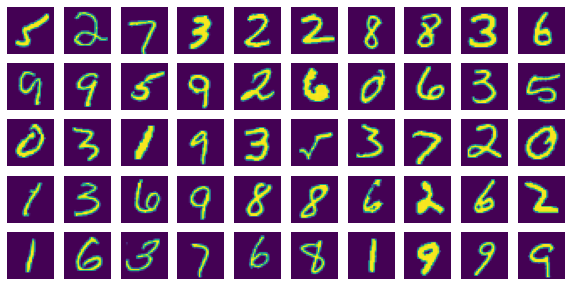

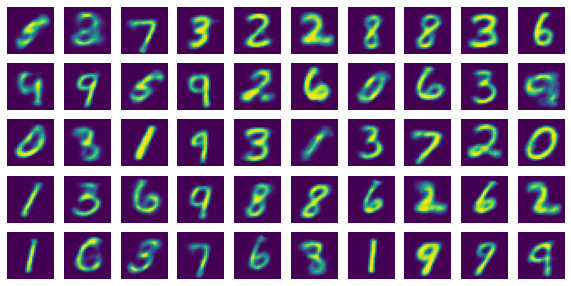

In [10]:
check_plot()